In [1]:
! pip install -q kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"minojsos","key":"4c61d1db040b01096a2a311efc28dd3d"}'}

In [3]:
! mkdir ~/.kaggle

In [4]:
! cp kaggle.json ~/.kaggle/

In [5]:
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
! kaggle datasets download -d shubham2703/five-crop-diseases-dataset

Dataset URL: https://www.kaggle.com/datasets/shubham2703/five-crop-diseases-dataset
License(s): CC-BY-NC-SA-4.0
100% 4.33G/4.33G [02:24<00:00, 39.3MB/s]
100% 4.33G/4.33G [02:24<00:00, 32.1MB/s]


In [7]:
! unzip five-crop-diseases-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: Crop Diseases Dataset/Crop Diseases/Crop___Disease/Rice/Rice___Leaf_Blast/IMG_20190419_125251.jpg  
  inflating: Crop Diseases Dataset/Crop Diseases/Crop___Disease/Rice/Rice___Leaf_Blast/IMG_20190419_125403.jpg  
  inflating: Crop Diseases Dataset/Crop Diseases/Crop___Disease/Rice/Rice___Leaf_Blast/IMG_20190419_125426.jpg  
  inflating: Crop Diseases Dataset/Crop Diseases/Crop___Disease/Rice/Rice___Leaf_Blast/IMG_20190419_125429.jpg  
  inflating: Crop Diseases Dataset/Crop Diseases/Crop___Disease/Rice/Rice___Leaf_Blast/IMG_20190419_125436.jpg  
  inflating: Crop Diseases Dataset/Crop Diseases/Crop___Disease/Rice/Rice___Leaf_Blast/IMG_20190419_125441.jpg  
  inflating: Crop Diseases Dataset/Crop Diseases/Crop___Disease/Rice/Rice___Leaf_Blast/IMG_20190419_125504.jpg  
  inflating: Crop Diseases Dataset/Crop Diseases/Crop___Disease/Rice/Rice___Leaf_Blast/IMG_20190419_130528.jpg  
  inflating: Crop Diseases Dataset/Crop Disea

Predict the type of rice disease based on images. These images were curated from a variety of other datasets that include:
*  A Dataset of Rice Leaf Disease Classification for Bangladeshi Local Rice
* "Rice Leafs" dataset from Kaggle
<br><br>

The complete dataset can be found here: https://www.kaggle.com/datasets/shubham2703/five-crop-diseases-dataset

In [8]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import os
import numpy as np
from glob import glob

Load the dataset and construct a pandas dataframe based on the path to the dataset and their labels. This is useful as it can then be used with Image Data Generator and flow from dataframe. This requires the columns to be filepath and label.

In [9]:
data_dir = "/content/Crop Diseases Dataset/Crop Diseases/Crop___Disease/Rice"

# Gather all images and labels
image_paths = glob(os.path.join(data_dir, "*/*.jpg"))  # Adjust for actual image extensions (e.g., .png)
labels = [os.path.basename(os.path.dirname(path)) for path in image_paths]

In [10]:
# Create a dataframe for easy splitting
data = pd.DataFrame({
    'filepath': image_paths,
    'label': labels
})

data.head(5)

,filepath,label
0,/content/Crop Diseases Dataset/Crop Diseases/C...,Rice___Healthy
1,/content/Crop Diseases Dataset/Crop Diseases/C...,Rice___Healthy
2,/content/Crop Diseases Dataset/Crop Diseases/C...,Rice___Healthy
3,/content/Crop Diseases Dataset/Crop Diseases/C...,Rice___Healthy
4,/content/Crop Diseases Dataset/Crop Diseases/C...,Rice___Healthy


In [11]:
data['label'].value_counts()

,count
label,
Rice___Healthy,1488
Rice___Neck_Blast,1000
Rice___Leaf_Blast,977
Rice___Brown_Spot,613


# Exploratory Data Analysis (EDA)
This is to understand the distribution of images across the different classes.

<ipython-input-17-22e51abbc335>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")


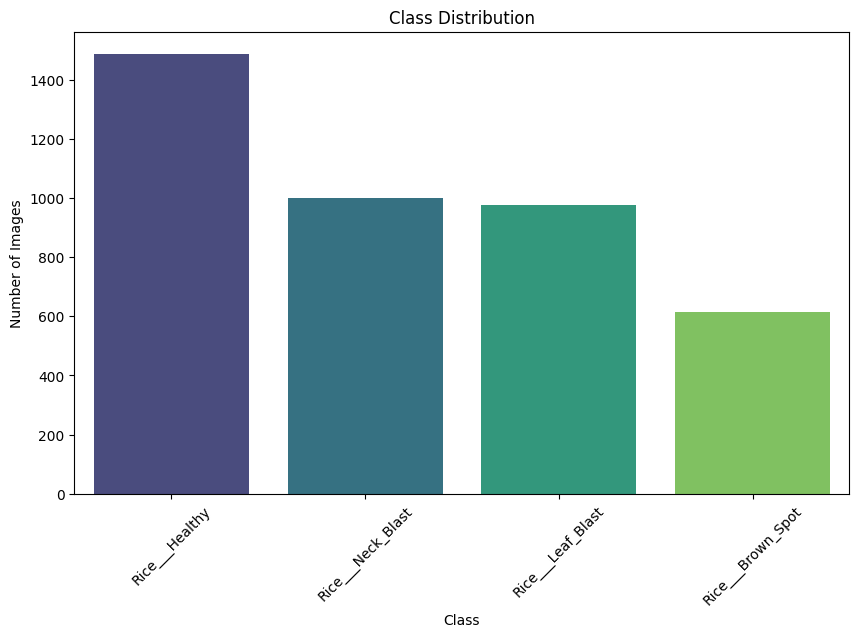

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot class distribution
class_counts = data['label'].value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.xticks(rotation=45)
plt.show()

It is evident that Healthy rice leaves have the highest representation in the dataset followed by Neck Blast and Leaf Blast while Brown Spot has the least number of images. This calls for the use of some data aguemntation

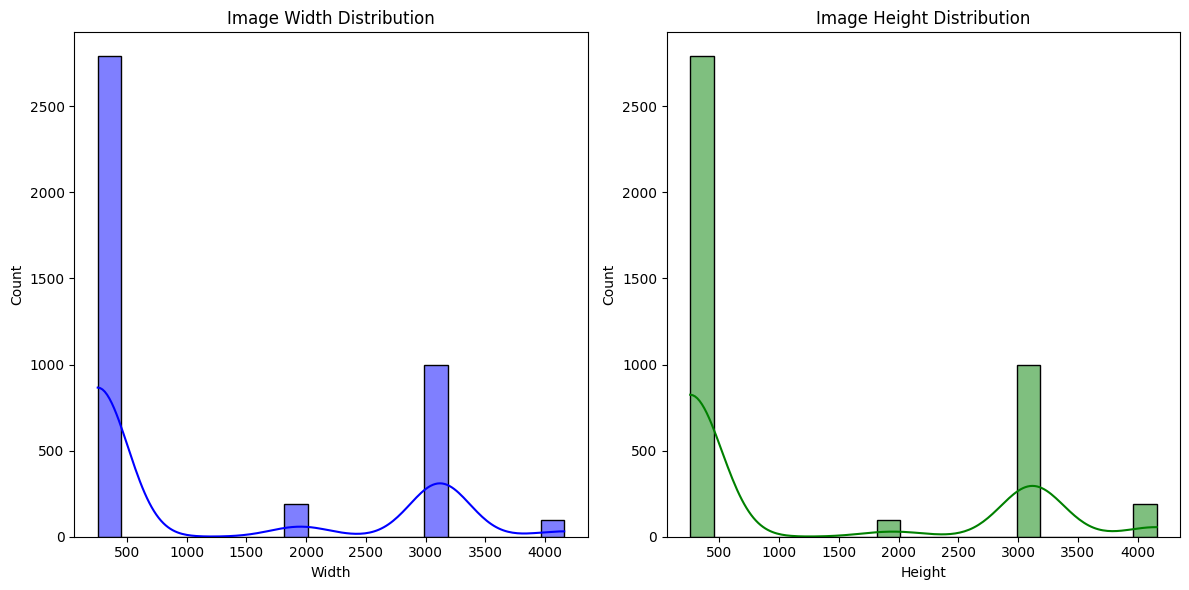

In [18]:
from PIL import Image

# Collect image dimensions
dimensions = [Image.open(path).size for path in data['filepath']]
widths, heights = zip(*dimensions)

# Plot distributions
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(widths, bins=20, kde=True, color='blue')
plt.title("Image Width Distribution")
plt.xlabel("Width")

plt.subplot(1, 2, 2)
sns.histplot(heights, bins=20, kde=True, color='green')
plt.title("Image Height Distribution")
plt.xlabel("Height")

plt.tight_layout()
plt.show()

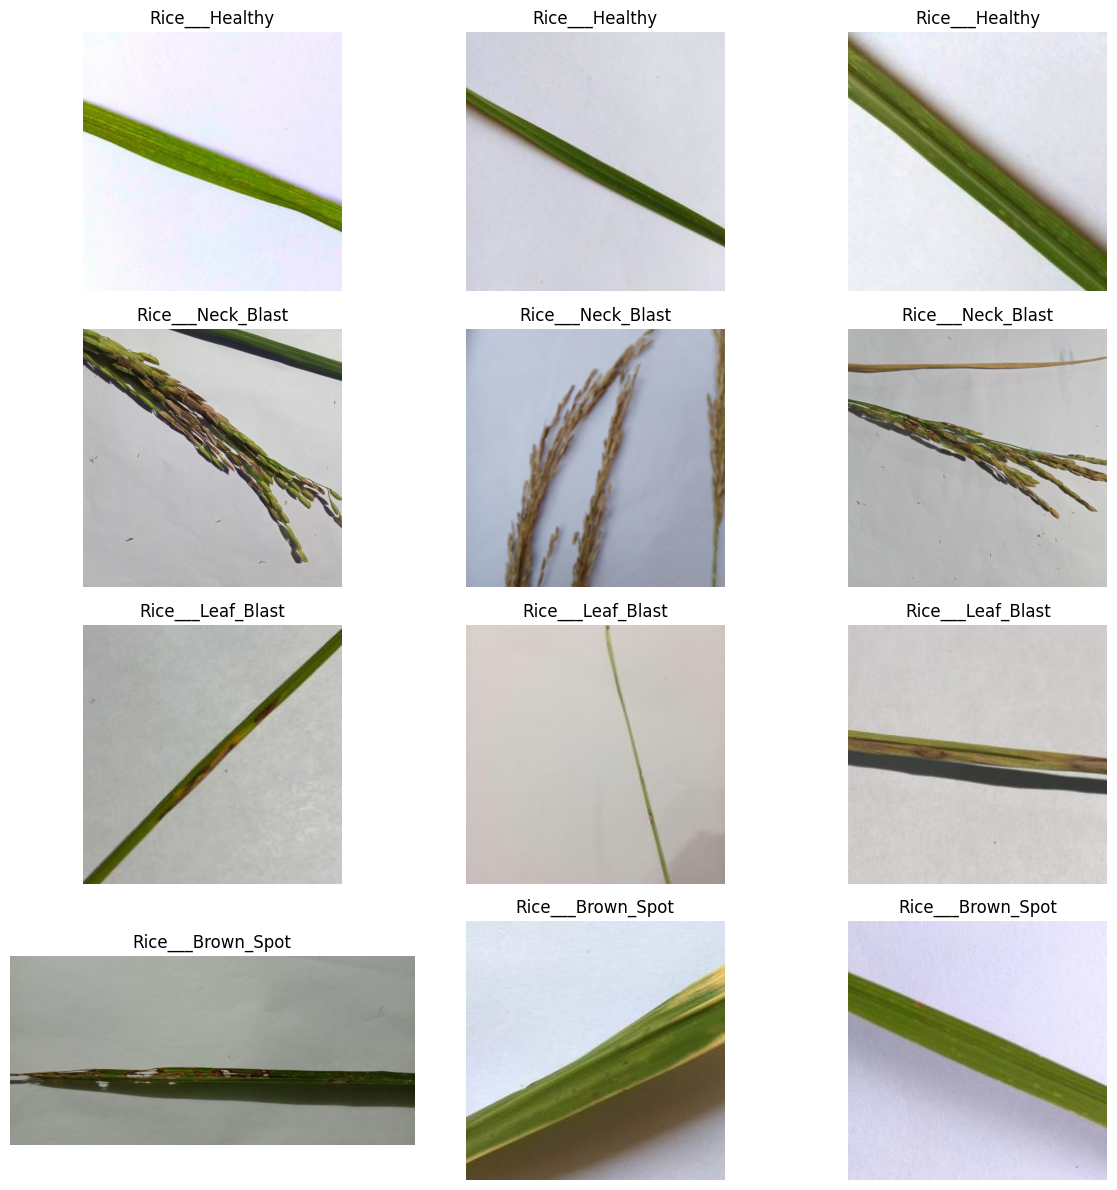

In [19]:
import random

def plot_sample_images(df, classes, num_samples=3):
    plt.figure(figsize=(12, len(classes) * 3))
    for i, class_name in enumerate(classes):
        class_samples = df[df['label'] == class_name].sample(num_samples, random_state=42)
        for j, path in enumerate(class_samples['filepath']):
            img = Image.open(path)
            plt.subplot(len(classes), num_samples, i * num_samples + j + 1)
            plt.imshow(img)
            plt.axis('off')
            plt.title(class_name)
    plt.tight_layout()
    plt.show()

# Plot sample images
plot_sample_images(data, class_counts.index, num_samples=3)

# Data Loading and Any Processing
The data is first divided into training and testing. This is required to train the model on one part and evaluation/validate on another portion of the dataset. In this case 20% of the dataset is used as the testing split.<br>
Due to the presence of imbalances in the dataset, Augmentation is used to augment the images and balance the dataset. This is applied across all the classes except the class with the most number of images - Healthy. This is because we want to augment and increase the number of images in the other classes to match that of the Healthy class.
<br>
ImageDataGenerator is used for Augmentation where traditional augmentation techniques such as rotiation, shifting, zooming, shear and flipping are used. As mentioned earlier, augmentation is performed until the number of images match that of the class with the most images.

In [12]:
# Split into training and validation sets
train_df, val_df = train_test_split(data, test_size=0.2, stratify=data['label'], random_state=42)

In [13]:
class_counts = train_df['label'].value_counts()
max_class_count = class_counts.max()

In [14]:
# Augmentation for minority classes
augmentor = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [15]:
# Balance the training dataset
balanced_train_data = []

for class_name, count in class_counts.items():
    class_data = train_df[train_df['label'] == class_name]

    # Add original images
    balanced_train_data.append(class_data)

    # If the class is imbalanced, apply augmentation
    if count < max_class_count:
        augment_samples_needed = max_class_count - count
        augmented_images = []
        augmented_labels = []

        for _, row in class_data.iterrows():
            img = tf.keras.preprocessing.image.load_img(row['filepath'], target_size=(128, 128))
            img_array = tf.keras.preprocessing.image.img_to_array(img)
            img_array = img_array.reshape((1,) + img_array.shape)

            # Generate augmented images
            for batch in augmentor.flow(img_array, batch_size=1):
                augmented_images.append(batch[0])
                augmented_labels.append(class_name)
                if len(augmented_images) >= augment_samples_needed:
                    break

        # Convert augmented images into a DataFrame
        augmented_df = pd.DataFrame({
            'filepath': [f"augmented_image_{i}" for i in range(len(augmented_images))],
            'label': augmented_labels
        })
        balanced_train_data.append(augmented_df)

Once the dataset is balanced after augmentation, then the training and testing generator instances are created using ImageDataGenerator. Only the training data has augmentation applied while the testing data is kept as is. The original images are then resized to 128 * 128. The original images are of size 256. The resize is to support for memory issues that may arise if larger/full resolution images are used. A batch size of 32 can also help reduce the number of images that are loaded into the memory at once.

In [16]:
# Combine original and augmented data
balanced_train_df = pd.concat(balanced_train_data, ignore_index=True)

# No augmentation for validation data
val_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = augmentor.flow_from_dataframe(
    balanced_train_df,
    x_col='filepath',
    y_col='label',
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_dataframe(
    val_df,
    x_col='filepath',
    y_col='label',
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)

Found 3262 validated image filenames belonging to 4 classes.
Found 816 validated image filenames belonging to 4 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 3567 invalid image filename(s) in x_col="filepath". These filename(s) will be ignored.
  warnings.warn(


In [17]:
# Classes
class_names = list(train_generator.class_indices.keys())

# Model Building and Evaluation
Different Models are built and trained on the augmented dataset to evaluate their performance on this dataset. Further tuning will have to be done based on the performance of the model. This is to ensure that the model works well.
Techniques such as Learning Rate reduce when a plateau is hit on the loss of the validation data, Early Stopping when no improvements in the validation loss is seen for the past 5 epochs are applied. Further, instances of the Best Model during training (based on validation loss) are saved. For this purpose Modelcheckpoint is used.
<br><br>
The following models are trained as part of the process with varying architectures:
* Custom CNN with Regularization and Dropout
* Custom CNN without Regularization or Dropout
* Pretrained VGG16
* Pretrained ResNet50
* Pretrained EfficientNetB3

In [18]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.regularizers import l2

## Custom CNN
The custom CNN model does not use transfer learning. This is a model built from scratch with 45 layers. 3 Convoluted layers where each is followed by a MaxPooling2D layer. Finally a Dense layer followed by a dropout layer and a Dense layer which is the classification layer. Asmentioned earlier, the Learning Rate Scheduler, Early Stopping and Model Checkpoints are all used as part of this model.
<br><br>
Adam Optimizer has been used as the optimizer function for this model. The reason for choosing Adam Optimizer is because of it's wide useage and it tends to converge much faster compared to other Optimization functions.<br>
The loss function chosen is Categorical CrossEntroy and this is ideal for multi-class classification where the target labels are one-hot encoded.<br>
We also use softmax as the activation function in the classification layer - This is the ideal function to be used for multi-class classification tasks.<br>
ReLU activation function was used in the intermediate layers (hidden layers) of the network to introduce non-linearity while addressing the vanishing gradients problem.

### Custom CNN with Regularization

In [26]:
# ----------------------------
# Custom CNN Model
# ----------------------------
def build_custom_cnn():
  model = Sequential([
    Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.01), input_shape=(128, 128, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.01)),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.01)),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(len(class_names), activation='softmax')
  ])
  return model

# Compile and train
def compile_and_train(model, train_gen, val_gen, epochs=10, model_name="model"):
  # Learning Rate Scheduler
  lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
  # Early Stopping if no Improvement
  early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
  # Save the Best Model when a Best Model is encountered
  model_checkpoint = ModelCheckpoint(f'best_{model_name}.keras', save_best_only=True)

  # Compile the Model using the ADAM Optimizer. Use Accuracy to measure the Model Performance
  model.compile(
    optimizer=Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
  )

  # Begin Training the model
  history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=epochs,
    callbacks=[lr_scheduler]
  )
  model.save(f"{model_name}.h5")
  return history

# Train custom CNN
custom_model = build_custom_cnn()
history_custom = compile_and_train(custom_model, train_generator, val_generator, epochs=20, model_name="custom_cnn")

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


102/102 ━━━━━━━━━━━━━━━━━━━━ 119s 1s/step - accuracy: 0.3642 - loss: 2.8624 - val_accuracy: 0.4755 - val_loss: 1.3227 - learning_rate: 0.0010
Epoch 2/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 120s 883ms/step - accuracy: 0.5797 - loss: 1.1354 - val_accuracy: 0.6140 - val_loss: 0.9826 - learning_rate: 0.0010
Epoch 3/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 103s 955ms/step - accuracy: 0.6067 - loss: 1.0061 - val_accuracy: 0.6299 - val_loss: 0.9728 - learning_rate: 0.0010
Epoch 4/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 94s 866ms/step - accuracy: 0.6436 - loss: 0.9170 - val_accuracy: 0.6703 - val_loss: 0.8812 - learning_rate: 0.0010
Epoch 5/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 102s 944ms/step - accuracy: 0.6389 - loss: 0.9046 - val_accuracy: 0.6152 - val_loss: 0.8689 - learning_rate: 0.0010
Epoch 6/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 94s 862ms/step - accuracy: 0.6459 - loss: 0.8857 - val_accuracy: 0.6924 - val_loss: 0.8426 - learning_rate: 0.0010
Epoch 7/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 104s 964ms/step - accuracy: 0.6487 - los

### Custom Model without Regularization
This is a replica of the above without regularization while the rest of the architecture is retained and follows a similar structure. The same set of activation functions and layers are used. We also use the same loss function - categorical cross-entropy along with the ADAM optimizer.

In [ ]:
def build_custom_cnn_vanilla():
  model = Sequential([
      Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
      MaxPooling2D(2, 2),
      Conv2D(64, (3, 3), activation='relu'),
      MaxPooling2D(2, 2),
      Conv2D(128, (3, 3), activation='relu'),
      MaxPooling2D(2, 2),
      Flatten(),
      Dense(128, activation='relu'),
      Dense(len(class_names), activation='softmax')
  ])
  return model

# Compile and train
def compile_and_train(model, train_gen, val_gen, epochs=10, model_name="model"):
  # Learning Rate Scheduler
  lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
  # Early Stopping if no Improvement
  early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
  # Save the Best Model when a Best Model is encountered
  model_checkpoint = ModelCheckpoint(f'best_{model_name}.keras', save_best_only=True)

  # Compile the Model using the ADAM Optimizer. Use Accuracy to measure the Model Performance
  model.compile(
    optimizer=Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
  )

  # Begin Training the model
  history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=epochs,
    callbacks=[lr_scheduler]
  )
  model.save(f"{model_name}.h5")
  return history

# Train custom CNN
custom_model_vanilla = build_custom_cnn_vanilla()
history_custom_vanilla = compile_and_train(custom_model_vanilla, train_generator, val_generator, epochs=20, model_name="custom_cnn_vanilla")

Epoch 1/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 111s 979ms/step - accuracy: 0.3664 - loss: 2.9182 - val_accuracy: 0.6078 - val_loss: 1.2462 - learning_rate: 0.0010
Epoch 2/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 125s 863ms/step - accuracy: 0.5621 - loss: 1.2573 - val_accuracy: 0.6127 - val_loss: 1.0751 - learning_rate: 0.0010
Epoch 3/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 92s 867ms/step - accuracy: 0.6049 - loss: 1.0677 - val_accuracy: 0.6679 - val_loss: 0.9616 - learning_rate: 0.0010
Epoch 4/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 91s 850ms/step - accuracy: 0.6185 - loss: 0.9906 - val_accuracy: 0.6176 - val_loss: 0.9373 - learning_rate: 0.0010
Epoch 5/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 94s 875ms/step - accuracy: 0.6200 - loss: 0.9619 - val_accuracy: 0.6495 - val_loss: 0.9111 - learning_rate: 0.0010
Epoch 6/20
 76/102 ━━━━━━━━━━━━━━━━━━━━ 19s 746ms/step - accuracy: 0.6345 - loss: 0.9351

## Pretrained Models
The following compile function will be re-used across the rest of the pretrained models that will be fine-tuned on the custom dataset. The pretrained models have been already trained on ImageNet dataset. And since these models are pretrained, the training is carried out for only 10 epochs instead of 20 epochs as before.

In [24]:
# Compile and train
def compile_and_train(model, train_gen, val_gen, epochs=10, model_name="model"):
  # Learning Rate Scheduler
  lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
  # Early Stopping if no Improvement
  early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
  # Save the Best Model when a Best Model is encountered
  model_checkpoint = ModelCheckpoint(f'best_{model_name}.keras', save_best_only=True)

  # Compile the Model using the ADAM Optimizer. Use Accuracy to measure the Model Performance
  model.compile(
    optimizer=Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
  )

  # Begin Training the model
  history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=epochs,
    callbacks=[lr_scheduler]
  )
  model.save(f"{model_name}.h5")
  return history

### VGG16 Model
The VGG16 model from Keras has been used here: https://keras.io/api/applications/vgg/

In [28]:
# ----------------------------
# Pre-trained VGG16
# ----------------------------
def build_vgg16():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(len(class_names), activation='softmax')
    ])
    base_model.trainable = False  # Freeze base model
    return model

vgg16_model = build_vgg16()
history_vgg16 = compile_and_train(vgg16_model, train_generator, val_generator, epochs=10, model_name="vgg16")

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 136s 1s/step - accuracy: 0.4689 - loss: 1.2121 - val_accuracy: 0.6569 - val_loss: 0.8000 - learning_rate: 0.0010
Epoch 2/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 93s 850ms/step - accuracy: 0.6269 - loss: 0.8290 - val_accuracy: 0.6618 - val_loss: 0.7499 - learning_rate: 0.0010
Epoch 3/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 145s 900ms/step - accuracy: 0.6410 - loss: 0.8042 - val_accuracy: 0.6667 - val_loss: 0.7203 - learning_rate: 0.0010
Epoch 4/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 138s 861ms/step - accuracy: 0.6536 - loss: 0.7772 - val_accuracy: 0.6838 - val_loss: 0.7042 - learning_rate: 0.0010
Epoch 5/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 96s 902ms/step - accuracy: 0.6586 - loss: 0.7483 - val_accuracy: 0.7059 - val_loss: 0.6960 - learning_rate: 0.0010
Epoch 6/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 91s 846ms/step - accuracy: 0.6755 - loss: 0.7165 - val_accuracy: 0.6863 - val_loss: 0.6807 - learning_rate: 0.0010
Epoch 7/10
102/102 

### ResNet50 Model
The ResNet50 model from Keras has been used here: https://keras.io/api/applications/resnet/

In [27]:
# ----------------------------
# Pre-trained ResNet50
# ----------------------------
def build_resnet50():
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(len(class_names), activation='softmax')
    ])
    base_model.trainable = False  # Freeze base model
    return model

resnet50_model = build_resnet50()
history_resnet50 = compile_and_train(resnet50_model, train_generator, val_generator, epochs=10, model_name="resnet50")

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Epoch 1/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 122s 981ms/step - accuracy: 0.2976 - loss: 1.4419 - val_accuracy: 0.3652 - val_loss: 1.3224 - learning_rate: 0.0010
Epoch 2/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 126s 883ms/step - accuracy: 0.3754 - loss: 1.3147 - val_accuracy: 0.4081 - val_loss: 1.2842 - learning_rate: 0.0010
Epoch 3/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 140s 854ms/step - accuracy: 0.4029 - loss: 1.2865 - val_accuracy: 0.4485 - val_loss: 1.2639 - learning_rate: 0.0010
Epoch 4/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 92s 865ms/step - accuracy: 0.4306 - loss: 1.2628 - val_accuracy: 0.4853 - val_loss: 1.2182 - learning_rate: 0.0010
Epoch 5/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 92s 866ms/step - accuracy: 0.4572 - loss: 1.2320 - val_accuracy: 0.5772 - val_loss: 1.1802 - learning_rate: 0.0010
Epoch 6/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 142s 862ms/step - accuracy: 0.4715 - loss: 1.2198 - val_accuracy: 0.5711 - val_loss: 1.1427 - learning_rate: 0.0010
Epoch 7/10
102/

### EfficientNetB4 Model
Keras provides different variants from EfficientNet model from B0 to up to B7. The difference mostly relies on the size of the architecture as they otherwise follow the same base structure. https://keras.io/api/applications/efficientnet/

In [25]:
from tensorflow.keras.applications import EfficientNetB4
# ----------------------------
# Pre-trained EfficientNetB4
# ----------------------------
def build_efficientnetb4():
  base_model = EfficientNetB4(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
  model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(len(class_names), activation='softmax')
  ])
  base_model.trainable = False  # Freeze base model
  return model

efficientnetb4_model = build_efficientnetb4()
history_efficientnetb4 = compile_and_train(efficientnetb4_model, train_generator, val_generator, epochs=10, model_name="efficientnetb4")

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


102/102 ━━━━━━━━━━━━━━━━━━━━ 194s 1s/step - accuracy: 0.2988 - loss: 1.4214 - val_accuracy: 0.3652 - val_loss: 1.3392 - learning_rate: 0.0010
Epoch 2/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 120s 877ms/step - accuracy: 0.3467 - loss: 1.3577 - val_accuracy: 0.3652 - val_loss: 1.3402 - learning_rate: 0.0010
Epoch 3/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 93s 874ms/step - accuracy: 0.3609 - loss: 1.3559 - val_accuracy: 0.3652 - val_loss: 1.3400 - learning_rate: 0.0010
Epoch 4/10
101/102 ━━━━━━━━━━━━━━━━━━━━ 0s 695ms/step - accuracy: 0.3592 - loss: 1.3607
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
102/102 ━━━━━━━━━━━━━━━━━━━━ 145s 891ms/step - accuracy: 0.3593 - loss: 1.3605 - val_accuracy: 0.3652 - val_loss: 1.3404 - learning_rate: 0.0010
Epoch 5/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 138s 858ms/step - accuracy: 0.3586 - loss: 1.3513 - val_accuracy: 0.3652 - val_loss: 1.3399 - learning_rate: 5.0000e-04
Epoch 6/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 92s 851ms/step - accuracy: 0.3583 - lo

## Evaluation of all Models
The following function is to generate the evaluation metrics for a given model. The evaluation involves generating and plotting the confusion matrix and generating the classification report. The classification report provides the Accuracy, Precision, Recall, F1-Score.

In [26]:
# ----------------------------
# Evaluation
# ----------------------------
def evaluate_model(model, generator):
  y_true = generator.classes
  y_pred = np.argmax(model.predict(generator), axis=1)

  print("\nClassification Report:")
  print(classification_report(y_true, y_pred, target_names=class_names))

  print("\nConfusion Matrix:")
  cm = confusion_matrix(y_true, y_pred)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
  disp.plot(cmap=plt.cm.Blues)
  plt.show()


Custom CNN:
26/26 ━━━━━━━━━━━━━━━━━━━━ 16s 610ms/step

Classification Report:
                   precision    recall  f1-score   support

Rice___Brown_Spot       0.14      0.11      0.12       123
   Rice___Healthy       0.36      0.38      0.37       298
Rice___Leaf_Blast       0.20      0.21      0.20       195
Rice___Neck_Blast       0.21      0.20      0.21       200

         accuracy                           0.25       816
        macro avg       0.22      0.22      0.22       816
     weighted avg       0.25      0.25      0.25       816


Confusion Matrix:


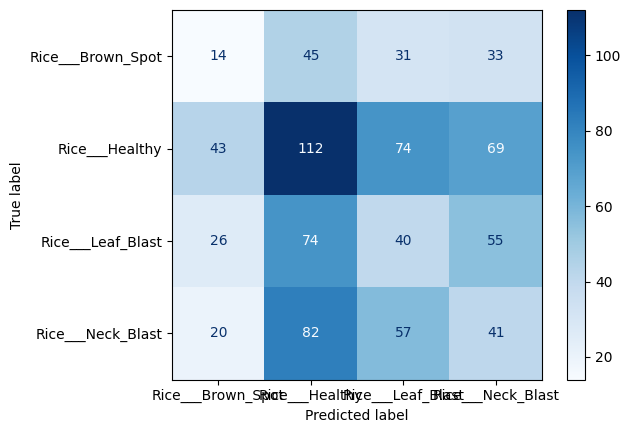


VGG16:
26/26 ━━━━━━━━━━━━━━━━━━━━ 17s 603ms/step

Classification Report:
                   precision    recall  f1-score   support

Rice___Brown_Spot       0.22      0.10      0.14       123
   Rice___Healthy       0.36      0.48      0.41       298
Rice___Leaf_Blast       0.23      0.19      0.21       195
Rice___Neck_Blast       0.24      0.24      0.24       200

         accuracy                           0.30       816
        macro avg       0.26      0.25      0.25       816
     weighted avg       0.28      0.30      0.28       816


Confusion Matrix:


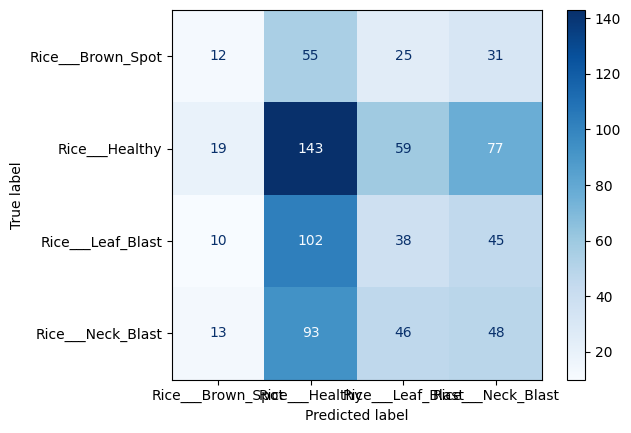


ResNet50:
26/26 ━━━━━━━━━━━━━━━━━━━━ 24s 772ms/step

Classification Report:
                   precision    recall  f1-score   support

Rice___Brown_Spot       0.00      0.00      0.00       123
   Rice___Healthy       0.34      0.48      0.40       298
Rice___Leaf_Blast       0.28      0.13      0.18       195
Rice___Neck_Blast       0.23      0.35      0.28       200

         accuracy                           0.29       816
        macro avg       0.21      0.24      0.21       816
     weighted avg       0.25      0.29      0.26       816


Confusion Matrix:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


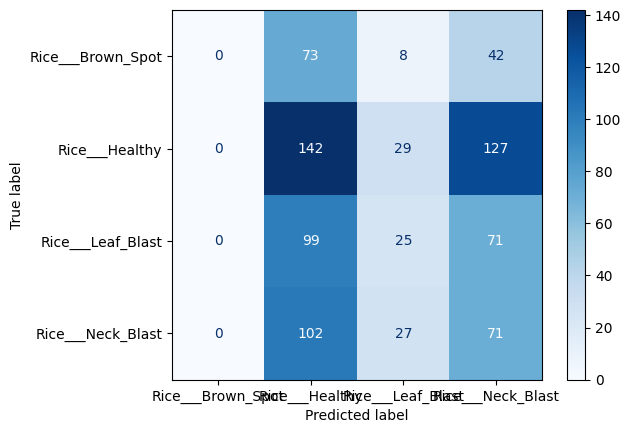

In [23]:
# Evaluate custom model
print("\nCustom CNN:")
evaluate_model(custom_model, val_generator)

# Evaluate custom vanilla model
print("\nCustom CNN Vanilla:")
evaluate_model(custom_model_vanilla, val_generator)

# Evaluate VGG16 model
print("\nVGG16:")
evaluate_model(vgg16_model, val_generator)

# Evaluate ResNet50 model
print("\nResNet50:")
evaluate_model(resnet50_model, val_generator)

# Evaluate EfficientNetB4 model
print("\EfficientNetB4:")
evaluate_model(efficientnetb4_model, val_generator)

Finally the training history for each of the models is plot to understand how the training process has been carried out. The training vs validation accuracy and loss can be visualized here.

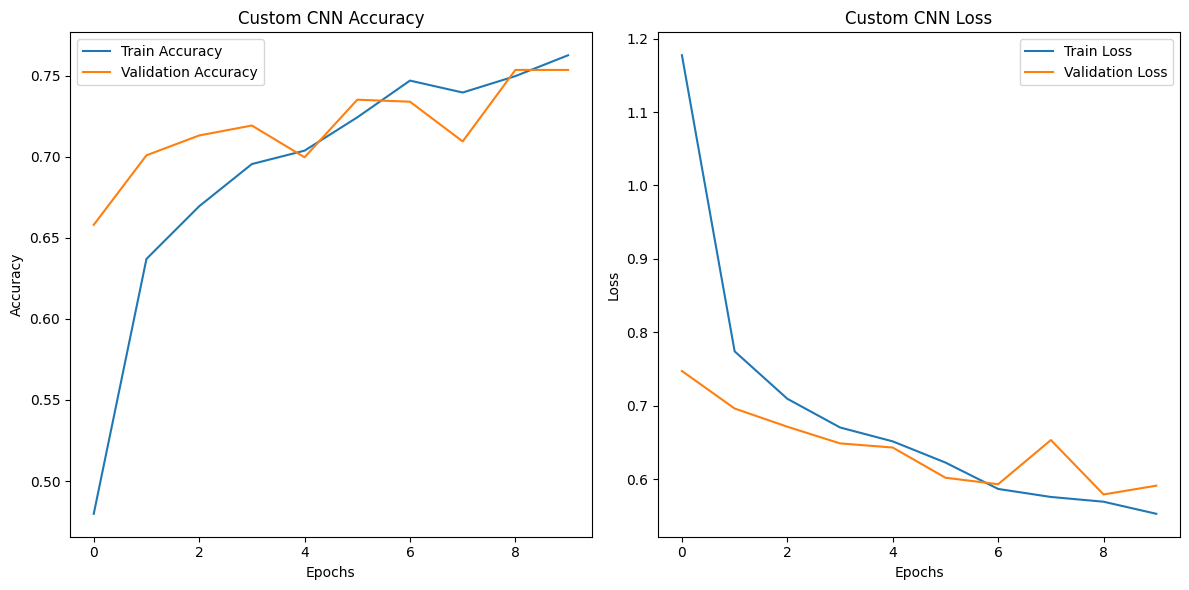

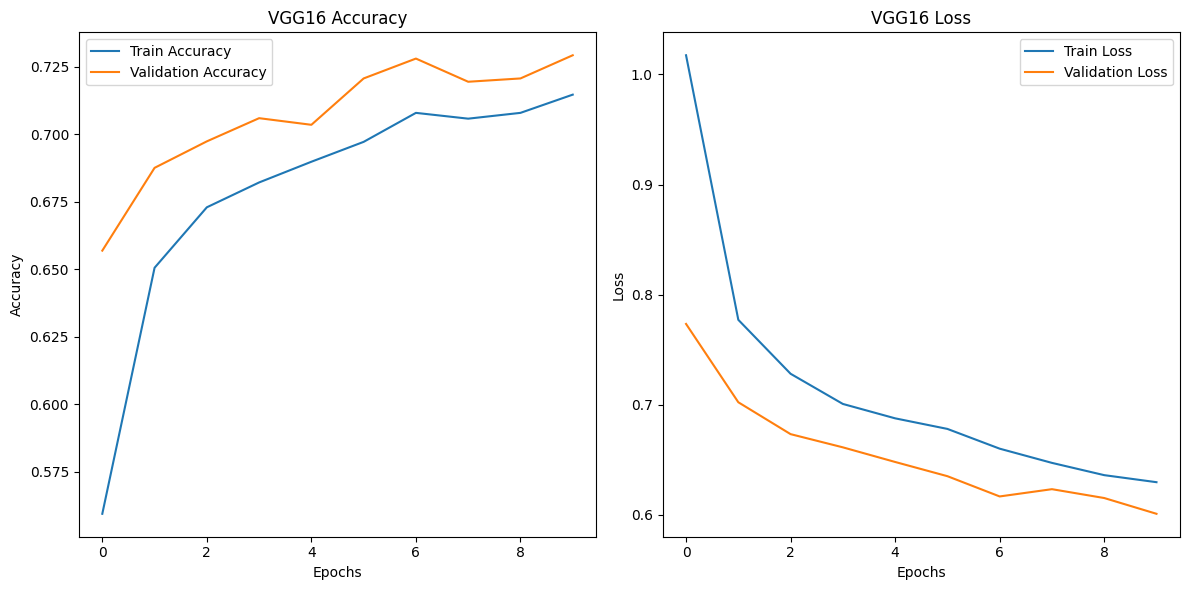

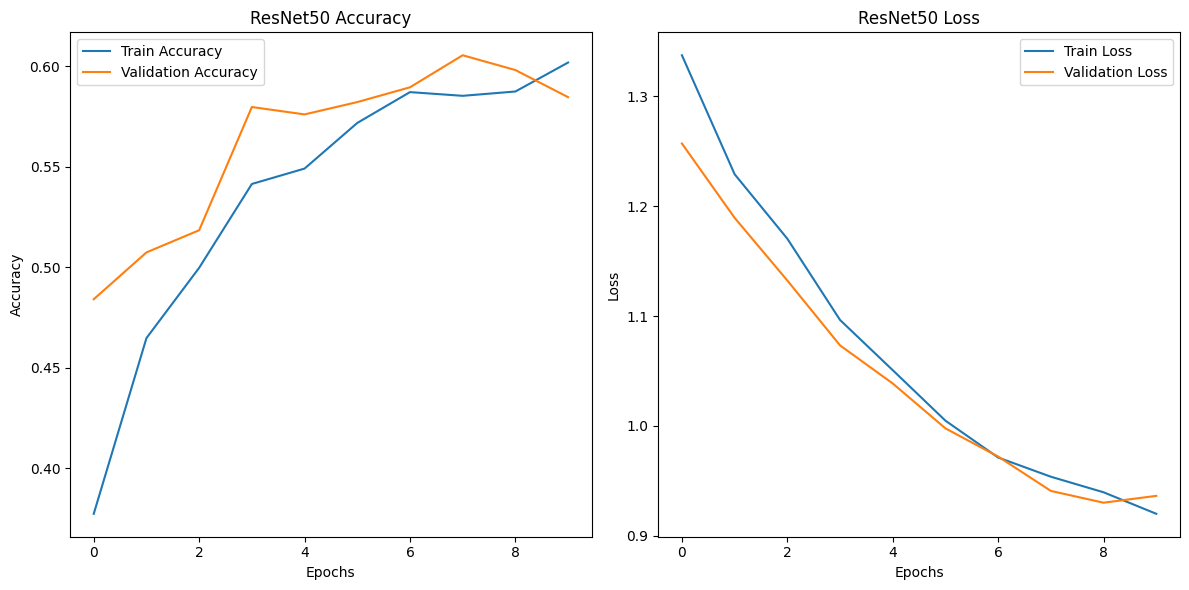

In [24]:
def plot_training_history(history, title):
    plt.figure(figsize=(12, 6))
    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{title} Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{title} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot history
plot_training_history(history_custom, "Custom CNN")
plot_training_history(history_custom_vanilla, "Custom CNN - Vanilla")
plot_training_history(history_vgg16, "VGG16")
plot_training_history(history_resnet50, "ResNet50")
plot_training_history(history_efficientnetb4, "EfficientNetB4")